In [1]:
!pip install catboost
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv(r'drive/MyDrive/Skripsi/citarum.csv')

In [4]:
#Dropping unnecessary columns
cols_to_drop = ['Measuring_Point', 'Date', 'Temperatur', 'Debit']
df = df.drop(cols_to_drop, axis=1)
df.head()

,TDS,TSS,NH3,Surfactant,Phenol,Phospate,BOD,COD,OG,NO3,DO,pH,Cl3,Fecal_Coliform,Total_Coliform,Class
0,81.0,35.0,0.025,740.0,40.0,0.040,3.89,18.41,1000.0,1.12,7.04,7.79,0.01,24000,30000,4
1,254.0,20.0,0.060,60.0,1.0,0.006,0.16,0.49,1000.0,0.17,6.72,7.13,0.01,80000,110000,4
2,208.0,61.0,0.040,60.0,1.0,0.060,2.81,5.76,1000.0,1.76,5.77,6.77,0.01,160000,160000,4
3,220.0,35.0,0.100,290.0,50.0,0.120,3.03,37.40,1000.0,1.21,6.20,7.72,0.01,24000,30000,4
4,148.0,32.0,0.025,120.0,70.0,0.070,3.04,12.80,1000.0,1.36,8.80,6.96,0.01,50000,110000,4


In [5]:
#Seperating X & y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [6]:
#Splitting test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 29)

In [7]:
#Applying data standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
#Apply Naive ROS and create new X_train & y_train
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [9]:
#Empty result dataframe
res = pd.DataFrame(index=['precision','recall','f1-score','accuracy'])

In [10]:
#Result Function
def result(clf, Classifier_Name, X_train, X_test):
  #Model Fitting
  clf.fit(X_train, y_train)
  
  #Showing performance result
  y_pred=clf.predict(X_test)
  from sklearn.metrics import classification_report
  clf_res = classification_report(y_test, y_pred, output_dict=True)

  #Append classifier result to result DataFrame
  res[str(Classifier_Name)] = [clf_res['weighted avg']['precision'],
                               clf_res['weighted avg']['recall'], 
                               clf_res['weighted avg']['f1-score'], 
                               clf_res['accuracy']]
  display(res)

  #Creating confusion matrix illustration
  from sklearn.metrics import ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, xticks_rotation="vertical", 
    display_labels=['Unsuitable', 'Very Poor', 'Poor', 'Good', 'Excellent'])
  disp.ax_.set_title("Confusion Matrix for " + str(Classifier_Name) + " Classifier")

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Decision Tree,Random Forest
precision,0.905882,0.866667
recall,0.921569,0.882353
f1-score,0.911765,0.872549
accuracy,0.921569,0.882353


array([False, False,  True, False, False, False, False, False, False,
       False, False, False,  True,  True, False])

,NH3,Cl3,Fecal_Coliform
0,-0.344078,-0.531178,-0.316527
1,0.301198,-0.531178,0.344059
2,-0.217160,-0.213541,-0.292976
3,-0.352762,-0.134132,-0.317762
4,-0.328046,-0.183762,-0.298491


array([15,  4,  1, 14, 12,  5, 13, 11, 10,  9,  8,  6,  3,  2,  7])

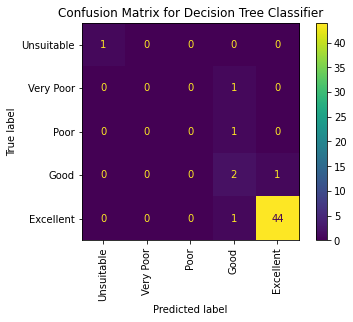

In [14]:
#Using Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

#Wrapper Feature Selection
from sklearn.feature_selection import RFECV
rfe_dt = RFECV(dt_clf)
rfe_dt.fit(X_train,y_train)
X_train_dt = rfe_dt.transform(X_train)
X_test_dt = rfe_dt.transform(X_test)

#Display Result
result(dt_clf, "Decision Tree", X_train_dt, X_test_dt)

#Creating selected features dataframe with corresponding column names
feature_idx_dt = rfe_dt.get_support(indices=True)
feature_names_dt = df.columns[feature_idx_dt]
features_dt = pd.DataFrame(X_train_dt, columns=feature_names_dt)
display(rfe_dt.get_support())
display(features_dt.head())

#Display Feature Ranking
from sklearn.feature_selection import RFE
selector_dt = RFE(dt_clf, step=1, n_features_to_select=1)
selector_dt = selector_dt.fit(X_train,y_train)
selector_dt.ranking_

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Decision Tree,Random Forest
precision,0.905882,0.866667
recall,0.921569,0.882353
f1-score,0.911765,0.872549
accuracy,0.921569,0.882353


array([False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False])

,NH3,Phenol
0,-0.344078,-0.341359
1,0.301198,1.530982
2,-0.217160,-0.464135
3,-0.352762,-0.515241
4,-0.328046,-0.464135


array([13, 15,  2,  7,  1,  4,  8, 10,  6, 11, 14, 12,  9,  3,  5])

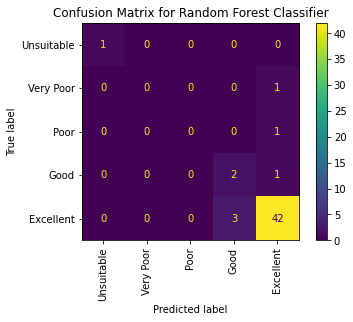

In [15]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

#Wrapper Feature Selection
rfe_rf = RFECV(rf_clf)
rfe_rf.fit(X_train,y_train)
X_train_rf = rfe_rf.transform(X_train)
X_test_rf = rfe_rf.transform(X_test)

#Display Result
result(rf_clf, "Random Forest", X_train_rf, X_test_rf)

#Creating selected features dataframe with corresponding column names
feature_idx_rf = rfe_rf.get_support(indices=True)
feature_names_rf = df.columns[feature_idx_rf]
features_rf = pd.DataFrame(X_train_rf, columns=feature_names_rf)
display(rfe_rf.get_support())
display(features_rf.head())

#Display Feature Ranking
selector_rf = RFE(rf_clf, step=1, n_features_to_select=1)
selector_rf = selector_rf.fit(X_train,y_train)
selector_rf.ranking_

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Decision Tree,Random Forest,SVM
precision,0.905882,0.866667,0.955882
recall,0.921569,0.882353,0.960784
f1-score,0.911765,0.872549,0.955539
accuracy,0.921569,0.882353,0.960784


array([False, False,  True, False, False, False, False, False, False,
       False,  True, False,  True,  True, False])

,NH3,DO,Cl3,Fecal_Coliform
0,-0.344078,1.859472,-0.531178,-0.316527
1,0.301198,0.523429,-0.531178,0.344059
2,-0.217160,0.112686,-0.213541,-0.292976
3,-0.352762,-0.207784,-0.134132,-0.317762
4,-0.328046,-0.704287,-0.183762,-0.298491


array([ 9, 14,  1, 12,  7, 11,  6,  5, 15, 13,  3,  8,  4,  2, 10])

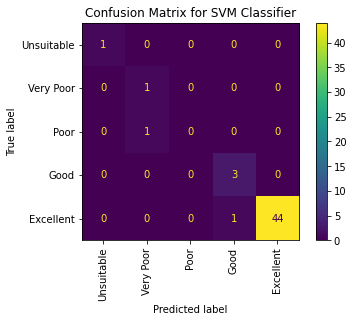

In [16]:
# Using Kernel SVM Classifier
from sklearn.svm import SVC
svm_clf = SVC(kernel = 'linear', random_state = 0)

#Wrapper Feature Selection
rfe_svm = RFECV(svm_clf)
rfe_svm.fit(X_train,y_train)
X_train_svm = rfe_svm.transform(X_train)
X_test_svm = rfe_svm.transform(X_test)

#Display Result
result(svm_clf, "SVM", X_train_svm, X_test_svm)

#Creating selected features dataframe with corresponding column names
feature_idx_svm = rfe_svm.get_support(indices=True)
feature_names_svm = df.columns[feature_idx_svm]
features_svm = pd.DataFrame(X_train_svm, columns=feature_names_svm)
display(rfe_svm.get_support())
display(features_svm.head())

#Display Feature Ranking
selector_svm = RFE(svm_clf, step=1, n_features_to_select=1)
selector_svm = selector_svm.fit(X_train,y_train)
selector_svm.ranking_

In [17]:
# Using Naive Bayes Classifier
#from sklearn.naive_bayes import GaussianNB
#nb_clf = GaussianNB()
#result(nb_clf, "Naive Bayes")

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Decision Tree,Random Forest,SVM,CatBoost
precision,0.905882,0.866667,0.955882,0.846475
recall,0.921569,0.882353,0.960784,0.882353
f1-score,0.911765,0.872549,0.955539,0.864024
accuracy,0.921569,0.882353,0.960784,0.882353


array([False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False,  True])

,NH3,Surfactant,Phenol,Total_Coliform
0,-0.344078,-0.472051,-0.341359,-0.151626
1,0.301198,0.572777,1.530982,-0.106323
2,-0.217160,-0.187336,-0.464135,-0.149547
3,-0.352762,-0.524047,-0.515241,-0.151714
4,-0.328046,0.050363,-0.464135,-0.150873


array([ 9, 11,  2,  4,  1,  7, 15,  8, 13, 12, 14,  5, 10,  6,  3])

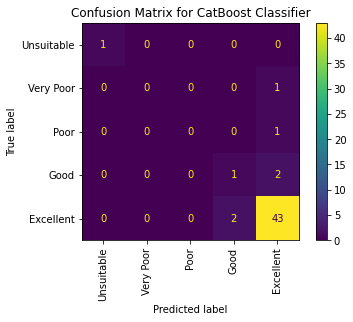

In [18]:
# Using CatBoost Classifier
from catboost import CatBoostClassifier
cb_clf = CatBoostClassifier(random_seed=42, logging_level='Silent')

#Wrapper Feature Selection
rfe_cb = RFECV(cb_clf)
rfe_cb.fit(X_train,y_train)
X_train_cb = rfe_cb.transform(X_train)
X_test_cb = rfe_cb.transform(X_test)

#Display Result
result(cb_clf, "CatBoost", X_train_cb, X_test_cb)

#Creating selected features dataframe with corresponding column names
feature_idx_cb = rfe_cb.get_support(indices=True)
feature_names_cb = df.columns[feature_idx_cb]
features_cb = pd.DataFrame(X_train_cb, columns=feature_names_cb)
display(rfe_cb.get_support())
display(features_cb.head())

#Display Feature Ranking
selector_cb = RFE(cb_clf, step=1, n_features_to_select=1)
selector_cb = selector_cb.fit(X_train,y_train)
selector_cb.ranking_